# Modelling based on sepsis data

In [4]:
data = pd.read_csv('data/data_mice.csv').drop(['testtrain', 'hadm_id'], axis=1)

y = data['icu_adm_flag']
X = data.drop(['icu_adm_flag', 'hosdeath_flag', 'ed_medgp_antibiotic_hrgp'], axis=1)
X['gender'] = X['gender'].apply(lambda x: 1 if x == 'M' else 0)
X['marital_status'] = X['marital_status'].apply(lambda x: 1 if 'Married' else 0)
X['insurance'] = X['insurance'].apply(lambda x: 1 if (x == 'Medicare' or x == 'Medicaid') else 0)
X = pd.concat([X, pd.get_dummies(data['ethnicity'], prefix='ethinicity')], axis=1)
X = X.drop(['ethnicity'], axis = 1)


In [5]:
from sklearn.model_selection import train_test_split

seed = 7

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


parameters = {
    'n_estimators': [90, 100, 120, 140],
    'max_depth':[1, 3, 5]
}

GBoost = GradientBoostingClassifier(n_estimators=100, max_depth=1, random_state=seed)
clf = GridSearchCV(GBoost, parameters, scoring='f1')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)


{'max_depth': 5, 'n_estimators': 140}
0.7438772816428416


In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.9072098411297441
Average Precision: 0.8251070911907405
Accuracy: 0.8637545501820073


# Calculate SHAP values

In [9]:
import shap

model = GradientBoostingClassifier(n_estimators=140, max_depth=5, random_state=seed)
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Apply failure exp[lainers

In [31]:
import importlib
import Failure
importlib.reload(Failure)

failure_explainer = Failure.Explainer(model, X_test, y_test, shap_values)
failure_explainer.find_failures()
_, _, _, _ = failure_explainer.present_false_positive_summary()
_, _, _, _ = failure_explainer.present_false_negative_summary()


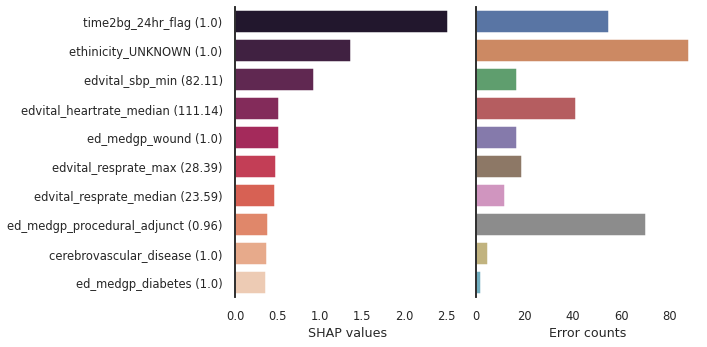

In [32]:
failure_explainer.plot_false_positive_summary()

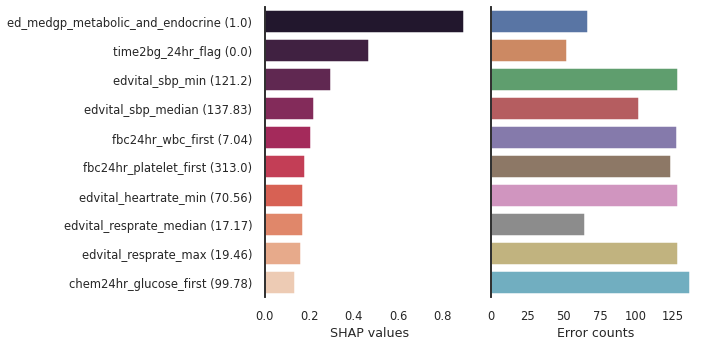

In [33]:
failure_explainer.plot_false_negative_summary()